# **E-commerce Customer Behaivor Analysis**

### About Dataset
- Dataset: **Brazilian E-Commerce Public Dataset by Olist**  
https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data?select=olist_geolocation_dataset.csv  
- Period: **2016.09.15 ~ 2018.08.29** (based on purchase behavior involving successfully delivered orders)  


<br>
This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

### Refereces

- Database setting reference: https://www.kaggle.com/code/arvinthsss/brazilian-e-commerce-dive-deep-using-sql


# **1.Executive Summary**

# **2.Database Setting**

In [14]:
# Dataset: Olist (SQLite) from Kaggle via kagglehub
import kagglehub

# Download latest version of the dataset
dataset_path = kagglehub.dataset_download("terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database")
print("Dataset downloaded to:", dataset_path)

# Connect to the SQLite database
import sqlite3
db_path = f"{dataset_path}/olist.sqlite"
conn = sqlite3.connect(db_path)


# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import re
import math
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na option is deprecated*")


# Visualization Setup
import seaborn as sns
import matplotlib.pyplot as plt


#----
# import plotly.express as px
# import plotly.io as pio
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import ipywidgets as widgets
# from IPython.display import display


# # Plotly rendering for Kaggle/Colab
# pio.renderers.default = "iframe_connected"

# # Pandas display options
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

# IPython output setting
%config InlineBackend.figure_format = "retina"


# View sample data
def view_table(table_name, limit=5):
    query = f"SELECT * FROM {table_name} LIMIT {limit}"
    return pd.read_sql_query(query, conn)


# Preview sample tables
display(view_table('orders'))
display(view_table('customers'))


Dataset downloaded to: /kaggle/input/e-commerce-dataset-by-olist-as-an-sqlite-database


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


# **3.Data Understanding**

## 3-1. Database Schema

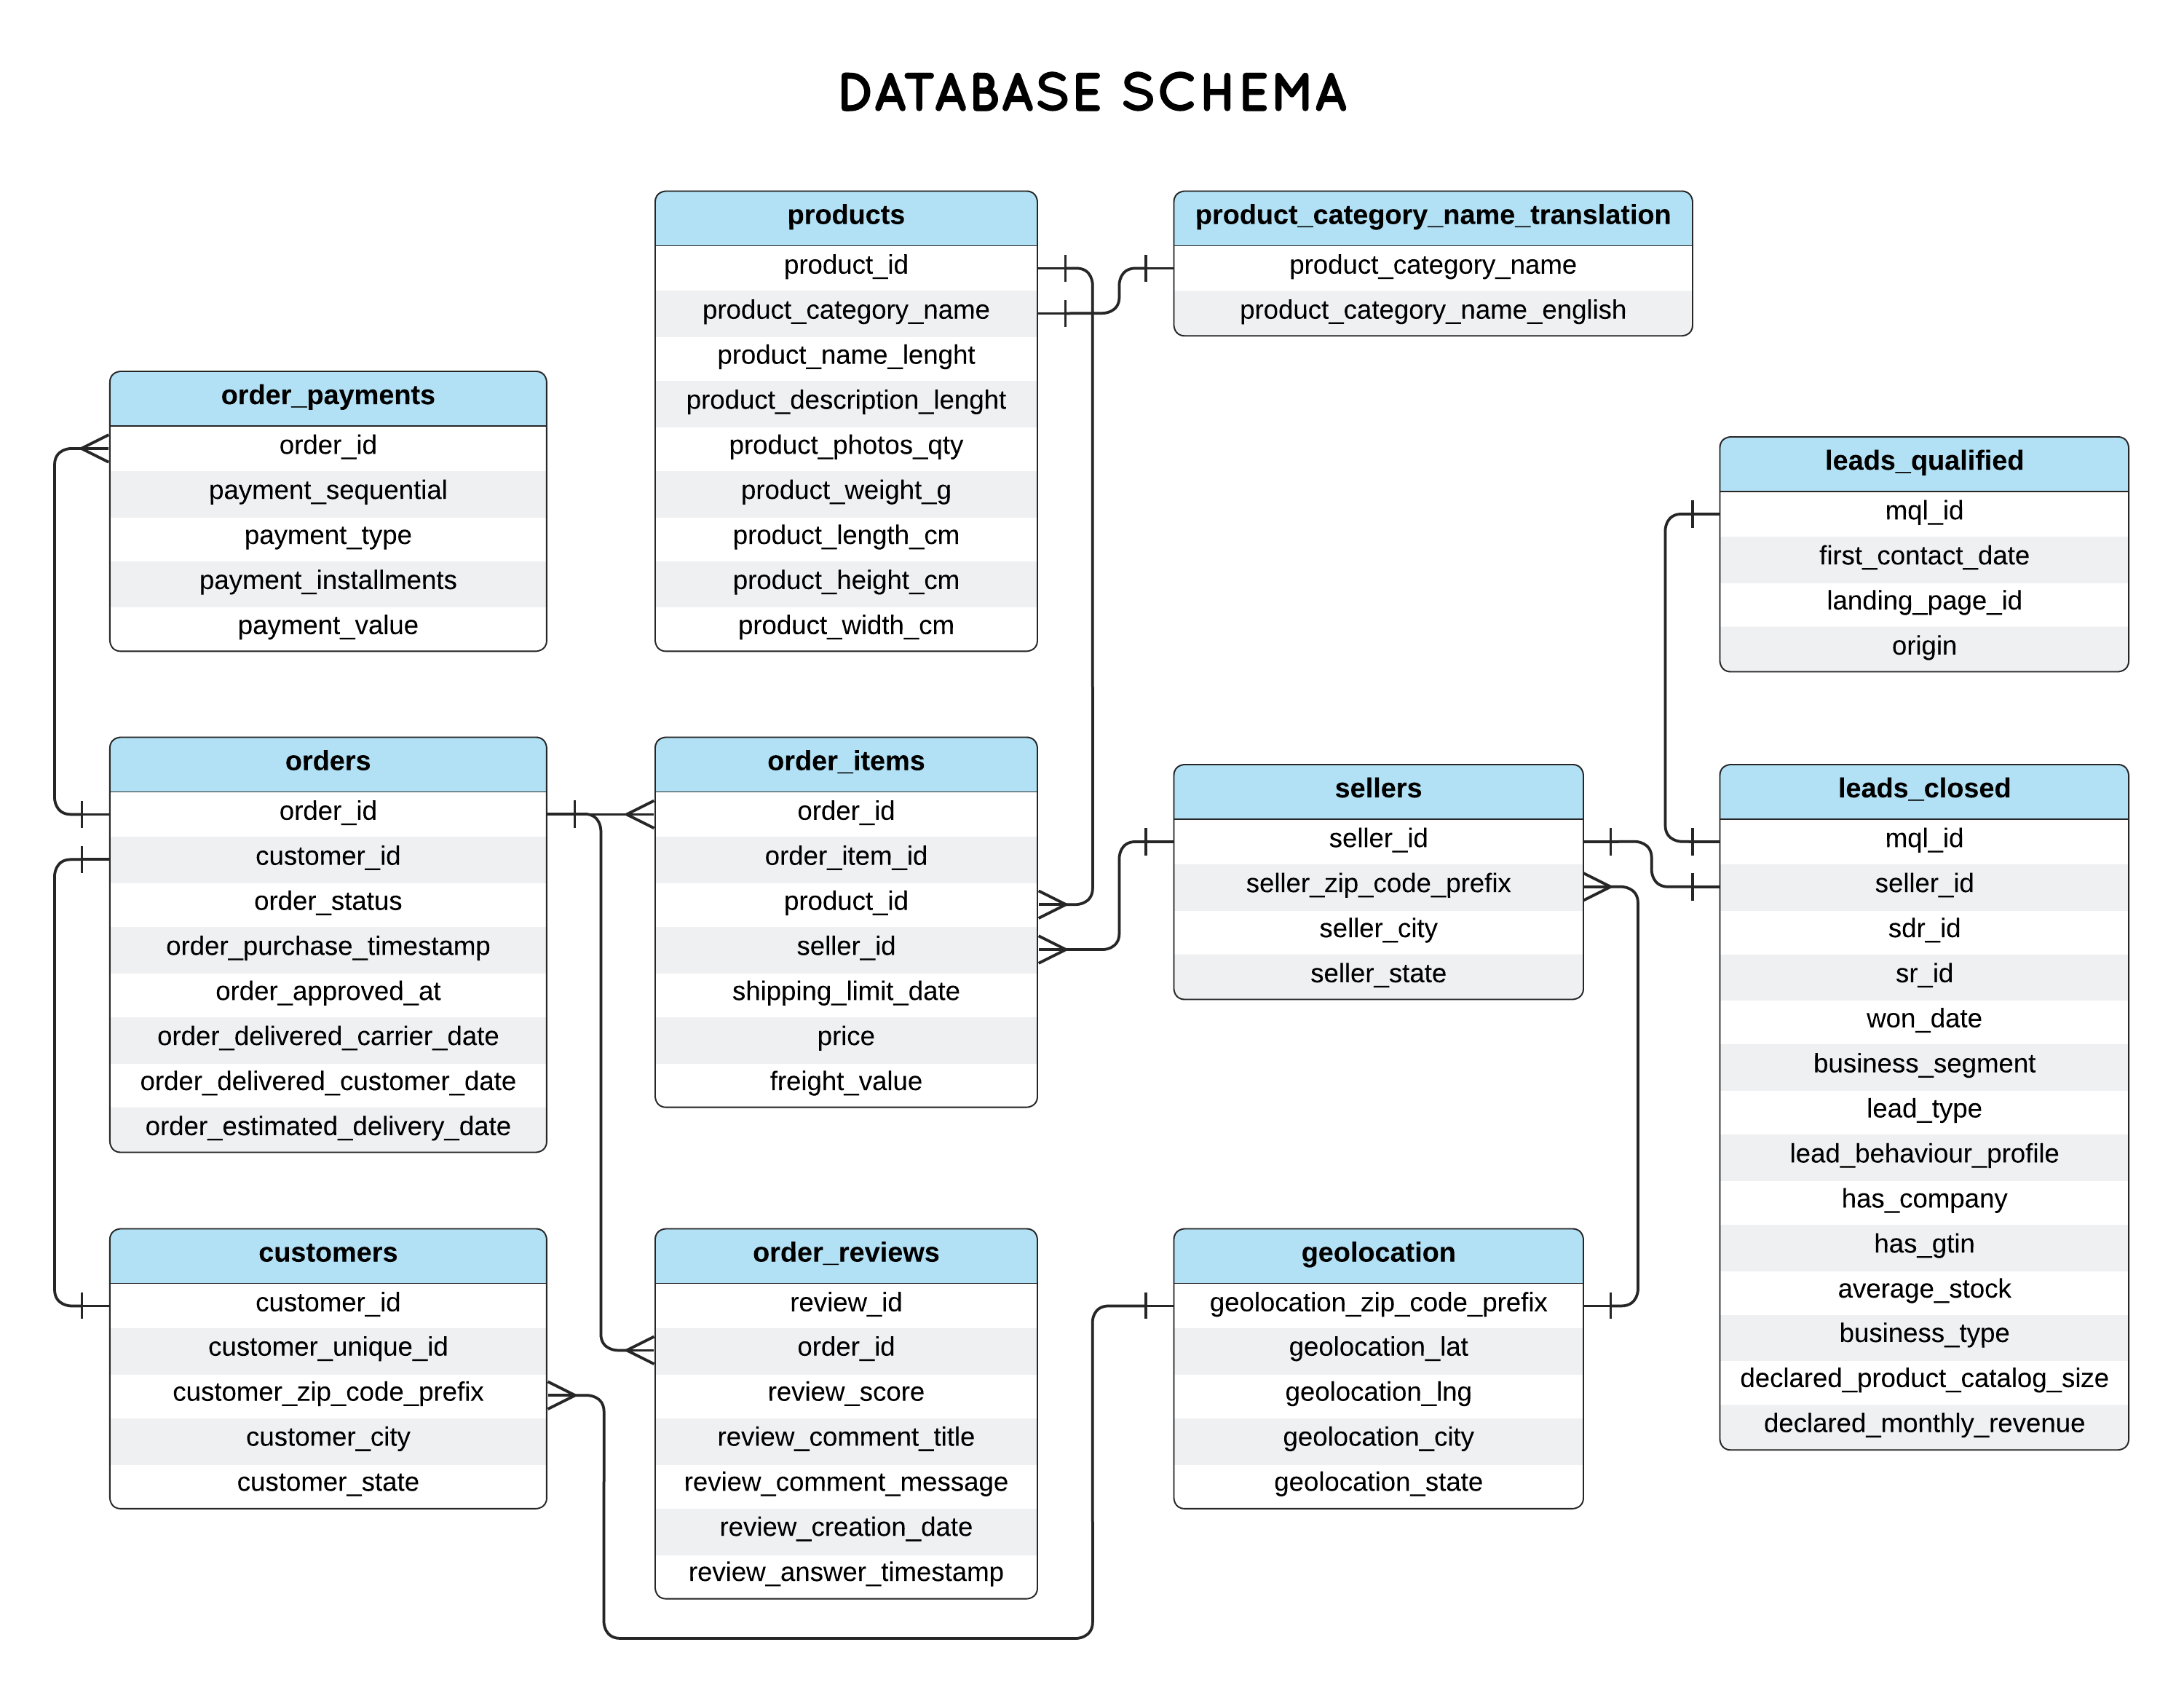

### 📦 Dataset Structure Overview: Olist E-commerce  
This project uses the Olist Brazilian E-commerce dataset in SQLite format. The database includes multiple relational tables that capture the full customer journey, from product listing and purchase to delivery, payment, and review.  
<br>

**Main E-commerce Tables**  
- **orders**: Contains order-level information such as status, purchase and delivery timestamps, and customer ID.  
- **order_items**: Line-item details for each order, including product ID, seller ID, price, and freight cost.  
- **order_reviews**: Customer reviews per order, including review score, comment content, and creation date.  
- **order_payments**: Payment method, number of installments, and amount paid per order.  
<br>

**Customer & Seller Tables**  
- **customers**: Customer location and anonymized ID, enabling segmentation by region.  
- **sellers**: Seller information including geographic location (ZIP code prefix, city, state).  
<br>

**Product Information**  
- **products**: Product attributes such as category, physical dimensions, description length, and image count.  
- **product_category_name_translation**: Mapping table for translating product categories from Portuguese to English.  
<br>

**Location & Mapping**  
- **geolocation**: ZIP code-level mapping to latitude/longitude, city, and state for geospatial analysis.  
<br>

**B2B Sales Funnel**  
- **leads_qualified**: Initial lead information from marketing channels, including contact date and origin.  
- **leads_closed**: Sales-qualified leads with conversion status, seller info, business profile, and estimated revenue.  


## 3-2. Table Preview

In [15]:
# Display all tables, columns, datatypes
for table in ['orders', 'customers', 'order_items', 'order_payments', 'order_reviews',
              'product_category_name_translation', 'sellers', 'geolocation',
              'leads_qualified', 'leads_closed']:
    print(f"📌 {table}")

    df = view_table(table)
    display(df)
    print("Data Types:")
    print(df.dtypes)
    print("\n" + "="*100 + "\n")

📌 orders


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Data Types:
order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object


📌 customers


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Data Types:
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object


📌 order_items


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Data Types:
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object


📌 order_payments


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


Data Types:
order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object


📌 order_reviews


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


Data Types:
review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object


📌 product_category_name_translation


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


Data Types:
product_category_name            object
product_category_name_english    object
dtype: object


📌 sellers


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


Data Types:
seller_id                 object
seller_zip_code_prefix     int64
seller_city               object
seller_state              object
dtype: object


📌 geolocation


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


Data Types:
geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object


📌 leads_qualified


,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search


Data Types:
mql_id                object
first_contact_date    object
landing_page_id       object
origin                object
dtype: object


📌 leads_closed


,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,None,None,None,reseller,None,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,None,None,None,reseller,None,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,None,None,None,reseller,None,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,None,None,None,None,reseller,None,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,None,None,None,manufacturer,None,0.0


Data Types:
mql_id                            object
seller_id                         object
sdr_id                            object
sr_id                             object
won_date                          object
business_segment                  object
lead_type                         object
lead_behaviour_profile            object
has_company                       object
has_gtin                          object
average_stock                     object
business_type                     object
declared_product_catalog_size     object
declared_monthly_revenue         float64
dtype: object




>✔️ **Check Point**  
>1. **customer_id** and **customer_unique_id** are used for different purposes.
>
>  - **customer_id**: A customer **identifier used at the order level**. Since the same customer may appear with different customer_ids across multiple orders, this field can lead to duplication in customer-level analysis.
>
>  - **customer_unique_id**: **A unique identifier for each customer**, consistent across all orders. This is used for person-level analysis such as repeat purchase behavior and lifetime value (LTV) calculations.
>
>2. **About Data type**: I did not pre-convert all data types after loading the data into Pandas.
Instead, I applied on-demand conversions only for columns used in analysis or visualization.
Since SQLite defines data types explicitly, date and numeric operations work reliably within SQL queries.
Even if some fields are loaded as object in Pandas, they can be flexibly handled as needed during the analysis.





In [16]:
# Dataset Period
query = '''
SELECT
    MIN(order_purchase_timestamp) AS start_date,
    MAX(order_purchase_timestamp) AS end_date
FROM orders
WHERE order_status = 'delivered';
'''

period = pd.read_sql_query(query, conn)
period

,start_date,end_date
0,2016-09-15 12:16:38,2018-08-29 15:00:37


>The dataset covers the period from September 15, 2016 to August 29, 2018, based on purchase behavior involving successfully delivered orders.

# **4. Customer Purchase Behavior**

> ### **🔎 Questions**
>
>- How many orders has each customer placed in total?
- What is the total monetary value spent by each customer?
- What is the average basket size (number of items per order) for each customer?

## 4-1. How many orders has each customer placed in total?
>### 📍 **Purpose**  
Identifies customer activity level and helps segment users into one-time, occasional, or frequent buyers. This is fundamental for retention analysis and loyalty program targeting.

### **📂 SQL**

In [17]:
# ---- a. Count total orders of each customer --- #
query = '''
SELECT
    c.customer_unique_id AS ID,
    COUNT(DISTINCT o.order_id) AS total_orders,
    MIN(o.order_purchase_timestamp) AS first_order_date,
    MAX(o.order_purchase_timestamp) AS last_order_date
FROM  customers AS c JOIN orders AS o
      ON c.customer_id = o.customer_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_unique_id
ORDER BY total_orders DESC
LIMIT 10;
'''

first_last_order = pd.read_sql_query(query, conn)
first_last_order

,ID,total_orders,first_order_date,last_order_date
0,8d50f5eadf50201ccdcedfb9e2ac8455,15,2017-06-18 22:56:48,2018-08-20 19:14:26
1,3e43e6105506432c953e165fb2acf44c,9,2017-09-18 18:53:15,2018-02-27 18:36:39
2,ca77025e7201e3b30c44b472ff346268,7,2017-10-09 12:34:39,2018-06-01 11:38:29
3,6469f99c1f9dfae7733b25662e7f1782,7,2017-09-19 01:02:44,2018-06-28 00:43:34
4,1b6c7548a2a1f9037c1fd3ddfed95f33,7,2017-11-13 16:44:41,2018-02-14 13:22:12
5,f0e310a6839dce9de1638e0fe5ab282a,6,2017-05-20 08:53:30,2018-04-05 09:04:45
6,dc813062e0fc23409cd255f7f53c7074,6,2017-07-01 04:22:21,2018-08-23 00:07:26
7,63cfc61cee11cbe306bff5857d00bfe4,6,2017-05-11 14:39:53,2018-05-28 17:20:02
8,47c1a3033b8b77b3ab6e109eb4d5fdf3,6,2017-08-07 14:14:22,2018-01-24 15:15:26
9,12f5d6e1cbf93dafd9dcc19095df0b3d,6,2017-01-05 14:18:03,2017-01-05 15:25:10


In [18]:
# ---- b. Average total orders of customers --- #

query2 = '''
SELECT
    ROUND(AVG(total_orders), 2) AS average_total_orders
FROM (
    SELECT
    c.customer_unique_id AS ID,
    COUNT(DISTINCT o.order_id) AS total_orders,
    MIN(o.order_purchase_timestamp) AS first_order_date,
    MAX(o.order_purchase_timestamp) AS last_order_date
    FROM  customers AS c JOIN orders AS o
          ON c.customer_id = o.customer_id
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_unique_id
)
'''

avg_total_orders = pd.read_sql_query(query2, conn)
avg_total_orders


,average_total_orders
0,1.03


> 🔎 **Observation**
- The most purchased count is **15** and the average order count of all customers is **1.03**.


### 📊 **Top 10 Customer's Order Periods**

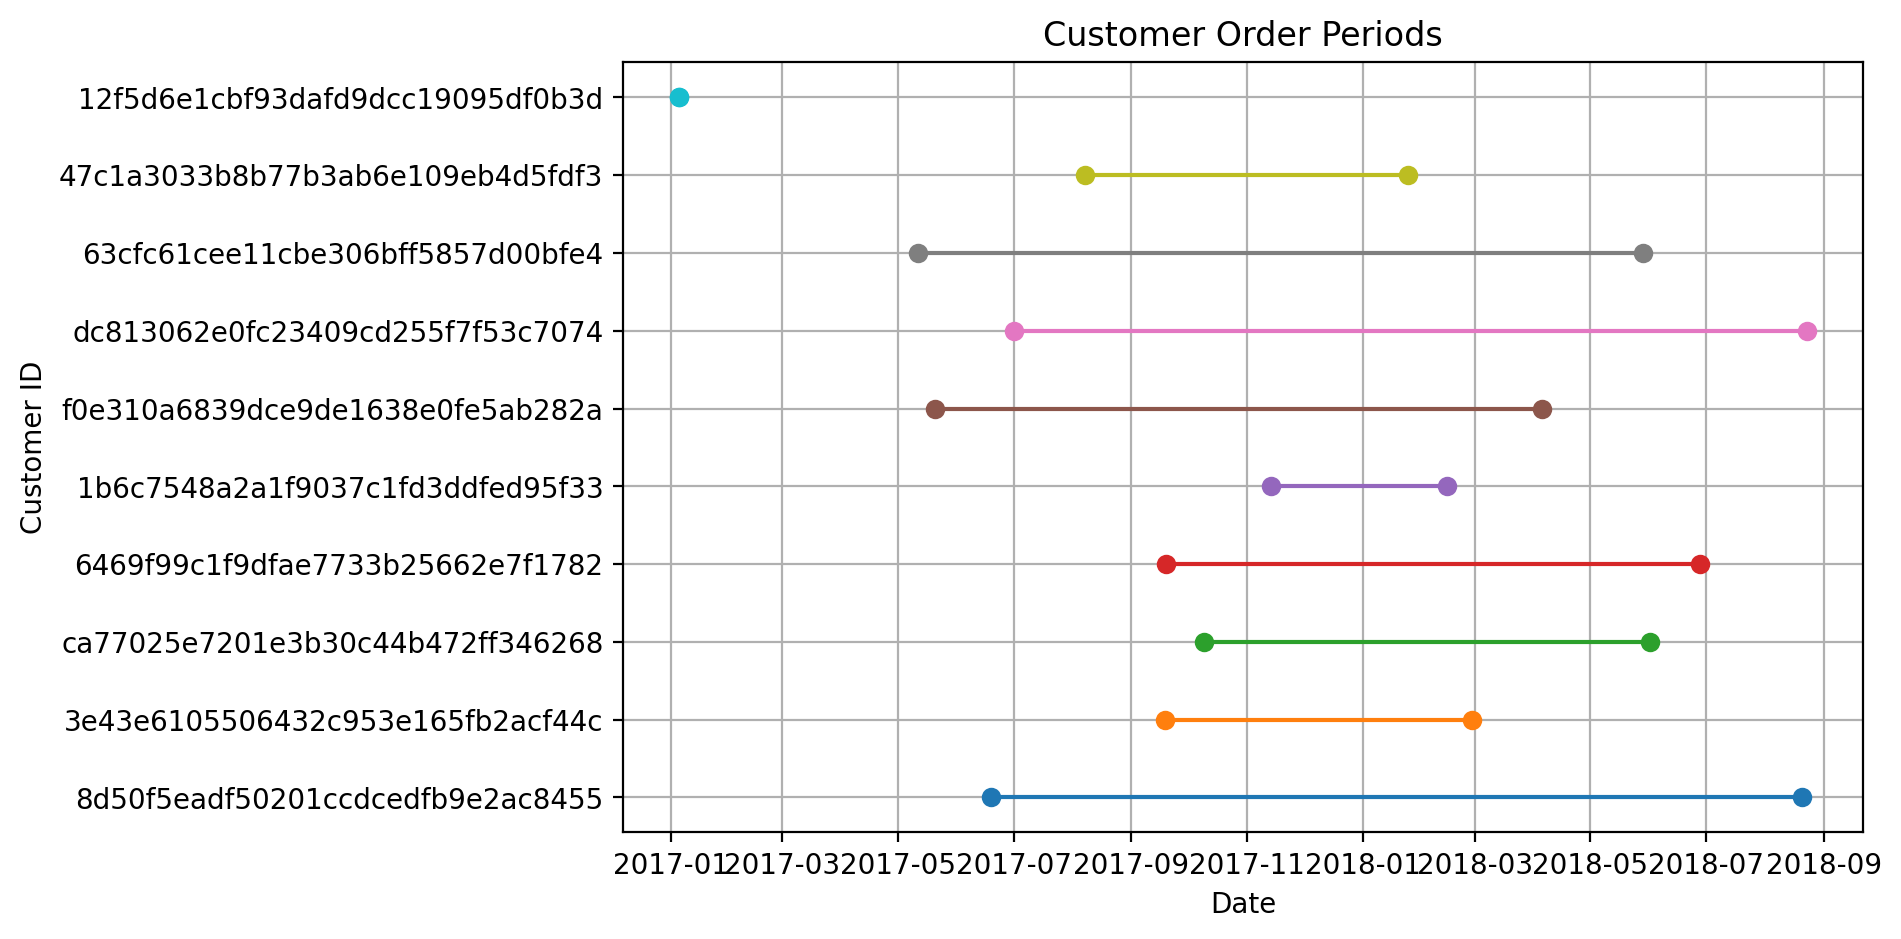

In [19]:
top10_df = pd.read_sql_query(query, conn)

top10_df['first_order_date'] = pd.to_datetime(top10_df['first_order_date'])
top10_df['last_order_date'] = pd.to_datetime(top10_df['last_order_date'])

plt.figure(figsize=(8, 5))
for i, row in top10_df.iterrows():
    plt.plot([row['first_order_date'], row['last_order_date']], [i, i], marker='o')
plt.yticks(range(len(top10_df)), top10_df['ID'])
plt.title('Customer Order Periods')
plt.xlabel('Date')
plt.ylabel('Customer ID')
plt.grid(True)
plt.show()

> 🔎 **Observation**
- This chart shows the activity period of top 10 customers, allowing us to see **which customers are consistently purchasing.**  
- Interesting activity is observed from customer '12f5d6e1cbf93dafd9dcc19095df0b3d'. **The customer appears to have ranked among the top 10 based on purchases made in a single day.** Let's investigate how this happened.

In [20]:
# checking the orders from customer '12f5d6e1cbf93dafd9dcc19095df0b3d'
query3 = '''
SELECT
    c.customer_unique_id,
    o.order_id,
    o.order_purchase_timestamp,
    o.order_status
FROM customers AS c
JOIN orders AS o ON c.customer_id = o.customer_id
WHERE c.customer_unique_id = '12f5d6e1cbf93dafd9dcc19095df0b3d'
ORDER BY o.order_purchase_timestamp
'''

df = pd.read_sql_query(query3, conn)
df

,customer_unique_id,order_id,order_purchase_timestamp,order_status
0,12f5d6e1cbf93dafd9dcc19095df0b3d,8a784d47854e4cbc5562362393d504db,2017-01-05 14:18:03,delivered
1,12f5d6e1cbf93dafd9dcc19095df0b3d,9b91ddcbd6cbceb83d4fd2462ca1f95e,2017-01-05 14:22:02,delivered
2,12f5d6e1cbf93dafd9dcc19095df0b3d,ca5a215980675471f0cf8199c041909a,2017-01-05 14:23:54,delivered
3,12f5d6e1cbf93dafd9dcc19095df0b3d,17fed53ba6dfef9b594ee2268642e2aa,2017-01-05 14:50:54,delivered
4,12f5d6e1cbf93dafd9dcc19095df0b3d,464de32dc84484c1d26df3e8e38e708b,2017-01-05 15:25:04,delivered
5,12f5d6e1cbf93dafd9dcc19095df0b3d,747996a66f5aa711deb8ae58f5ae46a0,2017-01-05 15:25:10,delivered


> 🔎 **Observation**
- This customer truely ordered 6 times in a day. Interesting.

## 4-2. What is the total monetary value spent by each customer?

> ### **📍 Purpose**
>Evaluates customer lifetime value (CLV/LTV) and revenue contribution. High spenders can be prioritized for premium service, promotions, or upsell opportunities.



### **📂 SQL(1) - Overview of All Customer**


>First, let’s explore all customers’ total payments and last order dates to understand the overall activation.

In [21]:
# ====================================================================================
# --!! Sample query for retrieving each customer's total spending and last order date
# --!! LIMIT is applied here only to limit preview output.
# --!! Full dataset is used in visualizations below.
# ====================================================================================

# All customer's total payments, last order dates
query = '''
SELECT
    c.customer_unique_id,
    MAX(o.order_purchase_timestamp) AS last_order_date,
    ROUND(SUM(p.payment_value), 2) AS total_payment
FROM  orders AS o JOIN order_payments AS p
      ON o.order_id = p.order_id
      JOIN customers as c ON c.customer_id = o.customer_id
WHERE o.order_status = 'delivered'
GROUP BY  c.customer_unique_id
LIMIT 10
'''

total_payment = pd.read_sql_query(query, conn)
total_payment['last_order_date'] = pd.to_datetime(total_payment['last_order_date']) # Change 'last_order_date's data type from string to date
total_payment

,customer_unique_id,last_order_date,total_payment
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,27.19
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,43.62
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,196.89
5,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,166.98
6,00050ab1314c0e55a6ca13cf7181fecf,2018-04-20 12:57:23,35.38
7,00053a61a98854899e70ed204dd4bafe,2018-02-28 11:15:41,419.18
8,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12,150.12
9,0005ef4cd20d2893f0d9fbd94d3c0d97,2018-03-12 15:22:12,129.76


### 📊 **Total Customer's Spending Distribution**

>To understand how total spending is distributed across all customers, I plotted a histogram of total_payment using a logarithmic scale on the x-axis.
>
>**Why Log Scale?**
- The spending values vary widely, with most customers spending relatively small amounts and a few spending significantly more.
- A regular histogram would be skewed, compressing most of the bars to the left and making it hard to interpret.
- Using a logarithmic scale helps compress low-value data and expand high-value ranges, making it easier to interpret skewed distributions at a glance.  

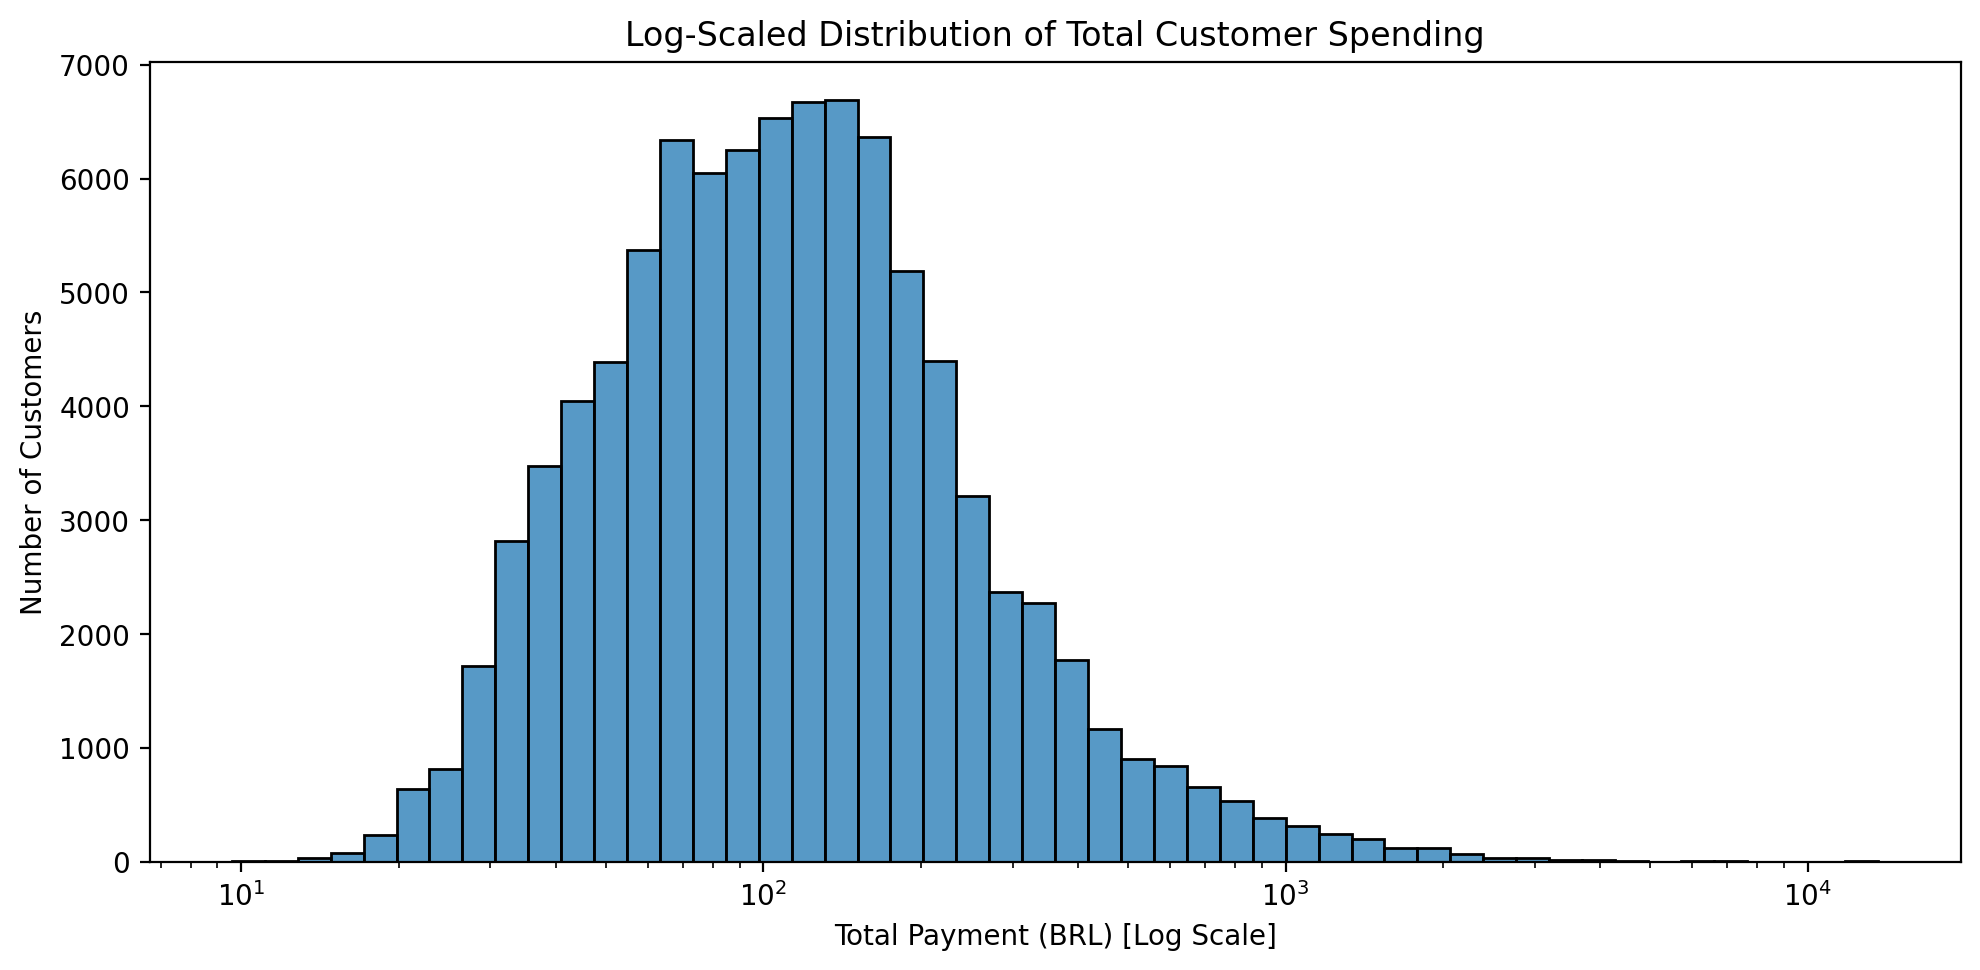

In [22]:
# All customer's Total Payment
query = '''
SELECT
    c.customer_unique_id,
    MAX(o.order_purchase_timestamp) AS last_order_date,
    ROUND(SUM(p.payment_value), 2) AS total_payment
FROM  orders AS o
JOIN order_payments AS p ON o.order_id = p.order_id
JOIN customers AS c ON c.customer_id = o.customer_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_unique_id
'''
total_payment = pd.read_sql_query(query, conn)
total_payment['last_order_date'] = pd.to_datetime(total_payment['last_order_date'])


# Log-Scaled All customer's spending
plt.figure(figsize=(10, 5))
sns.histplot(total_payment['total_payment'], bins=50, log_scale=True)
plt.title('Log-Scaled Distribution of Total Customer Spending')
plt.xlabel('Total Payment (BRL) [Log Scale]')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

> 🔎 **Observation**
- The **x-axis represents each customer’s total payment**, and the **y-axis shows the number of customers** within each spending range.
- The x-axis is shown in logarithmic scale, where 10¹ = 10 BRL, 10³ = 1000 BRL, etc.
- **Most customers spent less than 1000 BRL(approximately 250 CAD),** while only a few customers made significantly higher payments.
- Due to the log scale, the distribution of high-spending customers is less visually prominent. To explore these customers more closely, I will filter the top 20 customers and create a separate visualization below.

>🔎 **Is it a bad sign that most customers spent less than 1,000 BRL?**  
 1. **No — It can be normal depending on the business model.**   
In many e-commerce platforms like Amazon that focus on daily essentials or fast-moving consumer goods, it is common for customers to place multiple small orders.
In such cases, a low total spending per customer doesn't necessarily indicate low value — **purchase frequency and retention are more important metrics.**
>
>2. **Yes — If the platform focuses on high-ticket items.**  
If Olist primarily sells expensive items like electronics or furniture, a majority of customers spending less than 1,000 BRL (about 250CAD) could be a red flag.
This may indicate that **many customers are one-time buyers, which suggests issues with customer retention or loyalty.**
>
>3. **Yes — If the customer acquisition cost (CAC) is high.**  
In businesses where it’s expensive to acquire each new customer (e.g., via ads, promotions, onboarding), it becomes crucial that those customers generate enough revenue over time.
If the customer lifetime value (LTV) remains low, it fails to offset CAC, leading to poor unit economics and long-term profitability issues.
Even if the number of customers grows, low-spending behavior can erode margins and slow sustainable growth.




>💡 **Insight**  
- While the majority of customers spent under 1,000 BRL, this distribution may reflect a typical behavior in marketplaces with high transaction volume but low average basket size.
- However, if the business model relies on high-margin or recurring purchases, this could suggest under-monetization of the customer base, and warrants further investigation into retention, repeat rate, and LTV–CAC ratio.

### 📊 **Total Customer's Last Order Date Distribution**

>To understand the activity patterns of all customers, I visualized the distribution of their last order dates using a KDE plot.
>
>**Why KDE plot?**
- A KDE(Kernel Density Estimate) plot provides a smoothed version of a histogram, **making it easier to observe the overall distribution shape without being affected by bin size or noise.**
- In this case, it helps identify **when customers were most actively placing their final orders over time.**

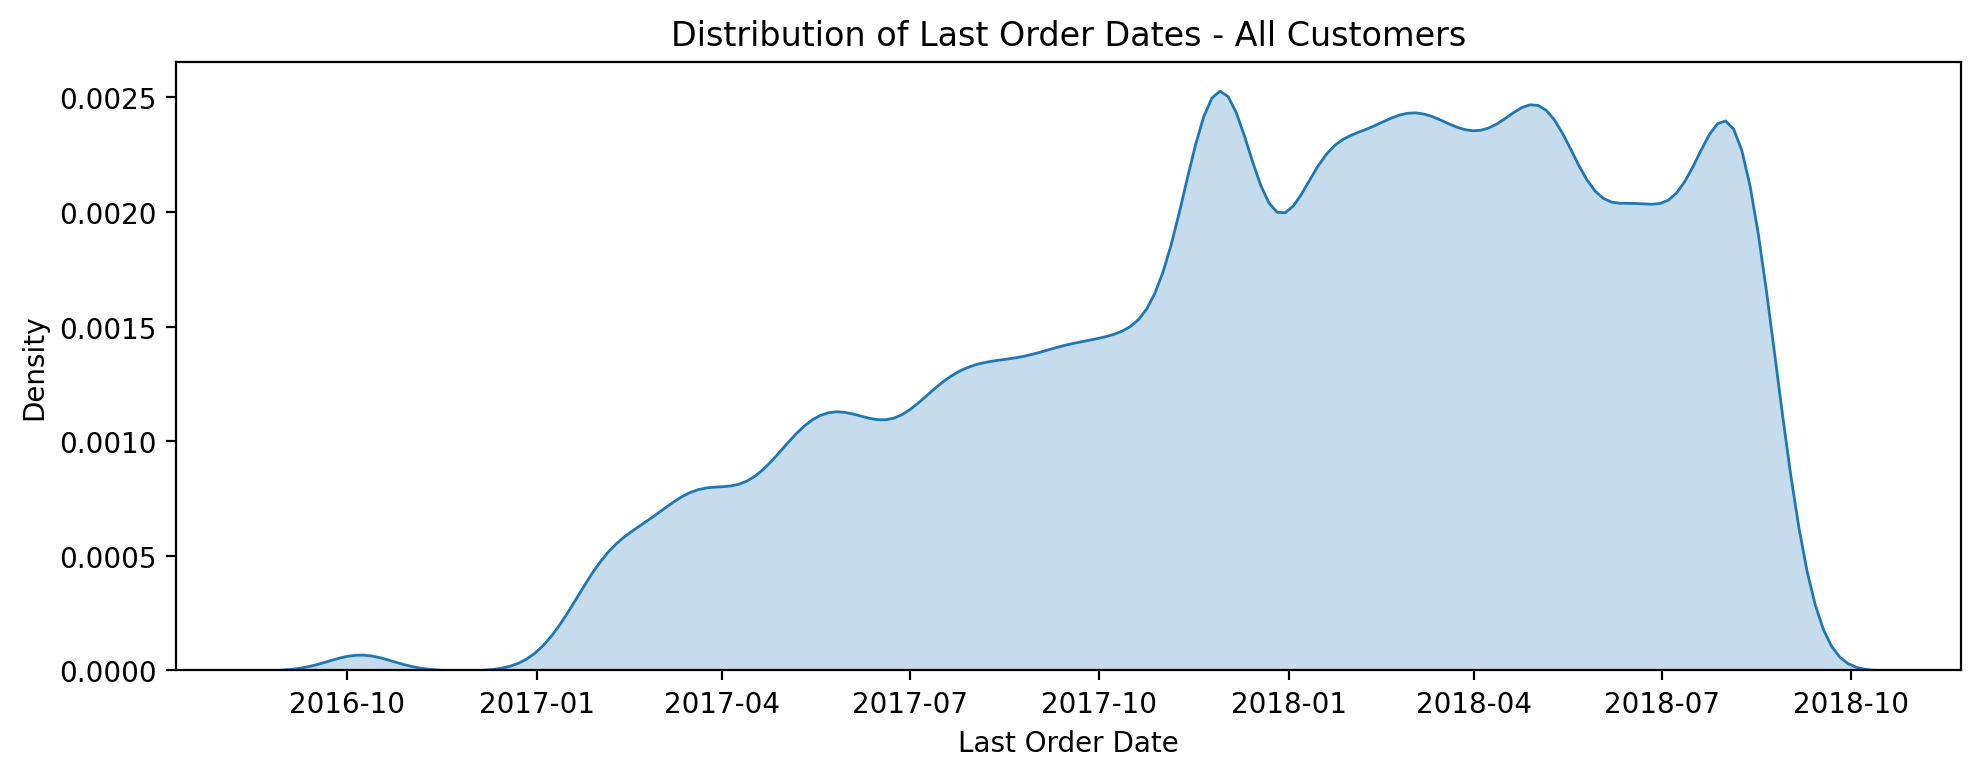

In [23]:
# KDE plot for visualization
plt.figure(figsize=(10, 4))
sns.kdeplot(data=total_payment, x='last_order_date', fill=True)
plt.title('Distribution of Last Order Dates - All Customers')
plt.xlabel('Last Order Date')
plt.tight_layout()
plt.show()

> 💡 **Insights**  
- The KDE curve shows that most customers’ last orders were concentrated between **early 2017 and mid-2018, with a noticeable peak around late 2017.**
- **The sharp drop after August 2018** suggests a decline in customer activity.  
- This insight could **inform churn analysis** or **help identify when engagement strategies might have been most effective.**

### **📂 SQL(2) - Top 20 Customers by Total spending**

In [24]:
# The highest 20 total payments, last order dates
query = '''
SELECT
    c.customer_unique_id,
    MAX(o.order_purchase_timestamp) AS last_order_date,
    ROUND(SUM(p.payment_value), 2) AS total_payment
FROM  orders AS o JOIN order_payments AS p
      ON o.order_id = p.order_id
      JOIN customers as c ON c.customer_id = o.customer_id
WHERE o.order_status = 'delivered'
GROUP BY  c.customer_unique_id
ORDER BY  total_payment DESC
LIMIT 20
'''

total_payment_20 = pd.read_sql_query(query, conn)
total_payment_20['last_order_date'] = pd.to_datetime(total_payment_20['last_order_date']) # Change 'last_order_date' data type string to date
total_payment_20

,customer_unique_id,last_order_date,total_payment
0,0a0a92112bd4c708ca5fde585afaa872,2017-09-29 15:24:52,13664.08
1,da122df9eeddfedc1dc1f5349a1a690c,2017-04-01 15:58:41,7571.63
2,763c8b1c9c68a0229c42c9fc6f662b93,2018-07-15 14:49:44,7274.88
3,dc4802a71eae9be1dd28f5d788ceb526,2017-02-12 20:37:36,6929.31
4,459bef486812aa25204be022145caa62,2018-07-25 18:10:17,6922.21
5,ff4159b92c40ebe40454e3e6a7c35ed6,2017-05-24 18:14:34,6726.66
6,4007669dec559734d6f53e029e360987,2017-11-24 11:03:35,6081.54
7,eebb5dda148d3893cdaf5b5ca3040ccb,2017-04-18 18:50:13,4764.34
8,48e1ac109decbb87765a3eade6854098,2018-06-22 12:23:19,4681.78
9,c8460e4251689ba205045f3ea17884a1,2018-08-08 14:27:15,4655.91


### 📊 **Top 20 Customers by Total spending**

/tmp/ipython-input-25-2650329094.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_payment_20['customer_unique_id'].str[:6], y=total_payment_20['total_payment'], palette='viridis')


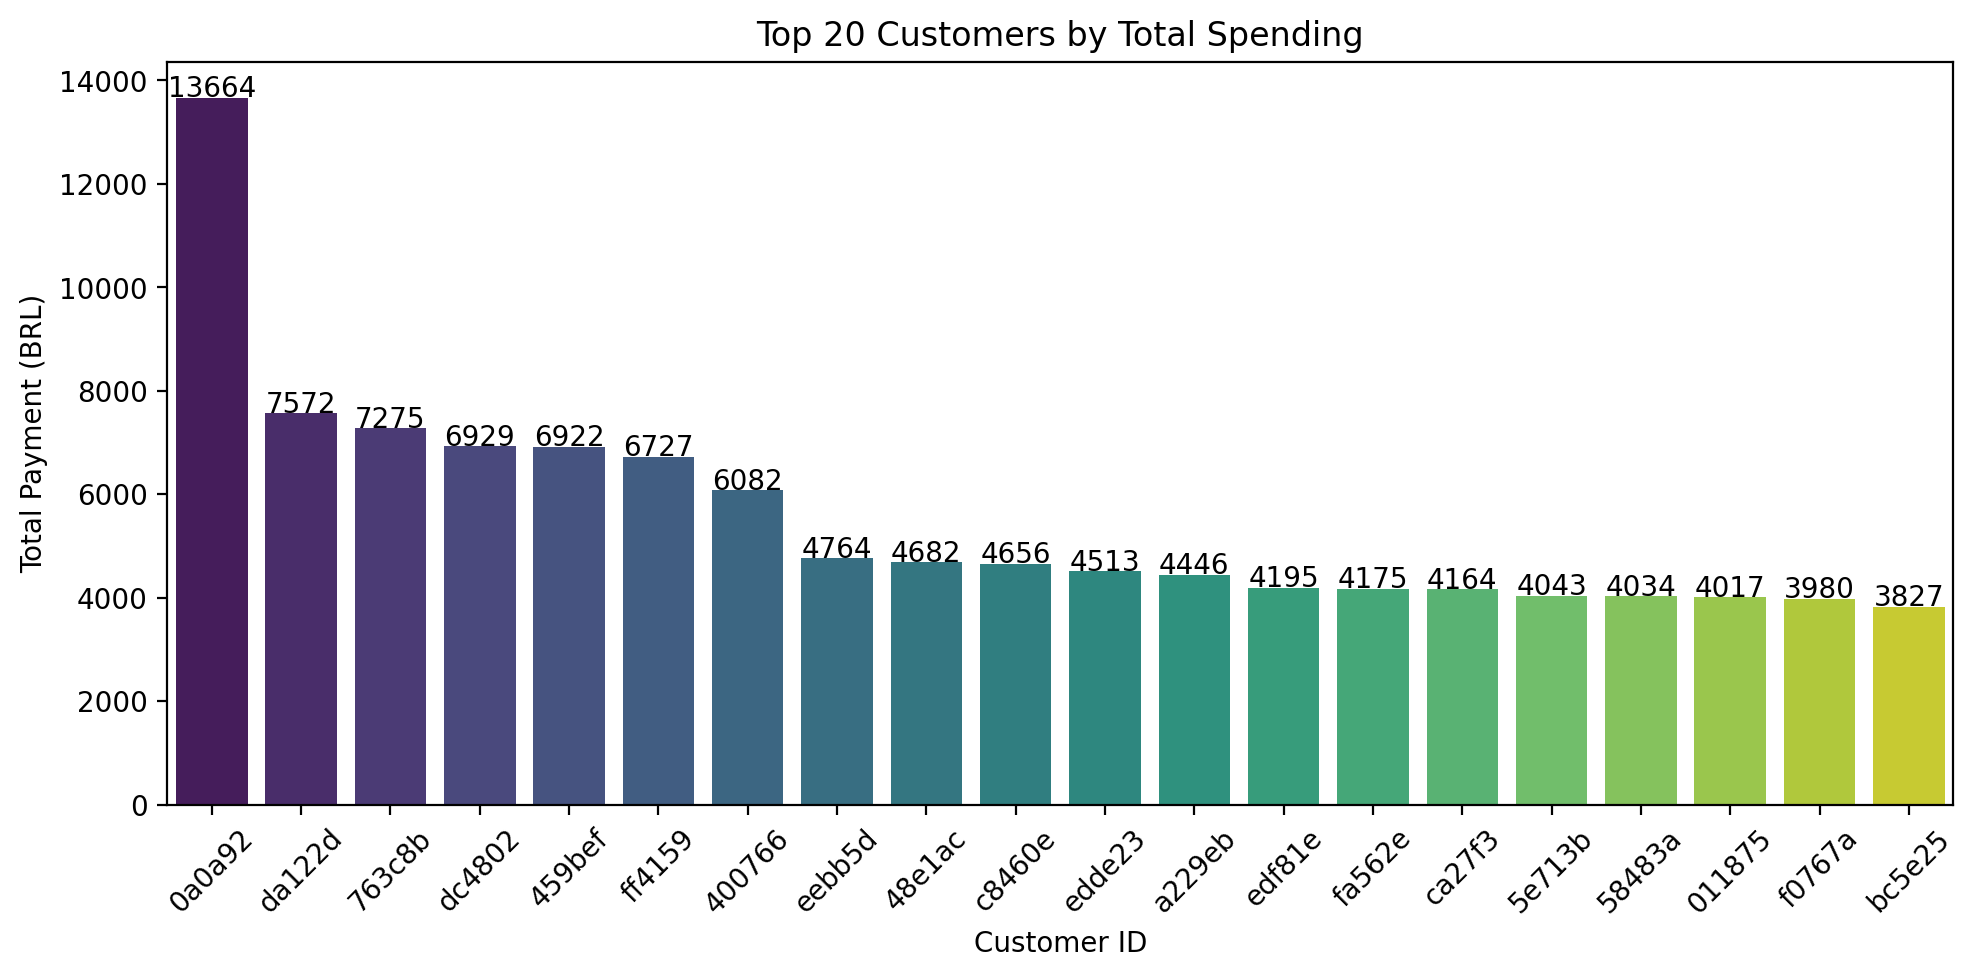

In [25]:
plt.figure(figsize=(10, 5))
sns.barplot(x=total_payment_20['customer_unique_id'].str[:6], y=total_payment_20['total_payment'], palette='viridis')

for index, row in total_payment_20.iterrows():
    plt.text(x=index,
             y=row['total_payment'] + 10,
             s=f"{row['total_payment']:.0f}",
             ha='center')

plt.title('Top 20 Customers by Total Spending')
plt.xlabel('Customer ID')
plt.ylabel('Total Payment (BRL)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> 🔎 **Observation**  
- The highest spending is **13,664 BRL(approx. 3,416 CAD)**, and 20th spending is **3,827 BRL(approx. 957 CAD)**.
- The top customer spent 13,664 BRL, which is nearly double the amount spent by the second-highest spender (7,572 BRL).
- The difference in spending between the 2nd and the 20th customer is less steep, ranging from 7,572 to 3,827 BRL.

> 💡 **Insights**  
- Even distribution from 2nd to 20th suggests that top customers are more evenly distributed in their spending, which is a healthy signal of customer value diversification.
- The fact that A customer needs to spend at least 3,827 BRL to be in the top 20 could be used as a threshold for VIP segmentation or targeted campaigns (e.g. loyalty rewards or retention offers).
- If any of these top 20 customers have been inactive recently (based on last order date), they represent high-value reactivation opportunities.

### 📊 **Top 20 Customer's Last Order Timeline**

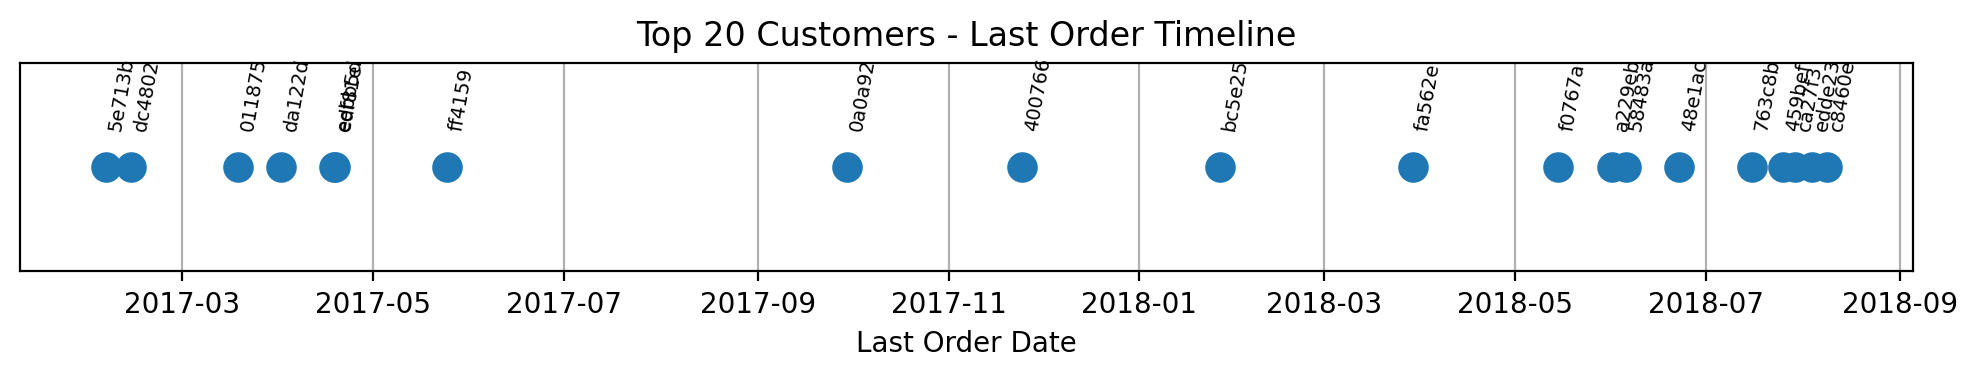

In [26]:
plt.figure(figsize=(10, 2))
plt.scatter(total_payment_20['last_order_date'], [1]*len(total_payment_20), s=100)

for i, row in total_payment_20.iterrows():
    plt.text(row['last_order_date'], 1.02, row['customer_unique_id'][:6], rotation=80, ha='left', size=7)

plt.title('Top 20 Customers - Last Order Timeline')
plt.yticks([])
plt.xlabel('Last Order Date')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

> 💡 **Insights**  
The timeline reveals that **15 out of the top 20 customers have not made any recent purchases**, with the majority of their last orders concentrated **between early 2017 and mid-2018.**
This suggests that **even high-value customers may have become inactive, highlighting a potential opportunity for re-engagement campaigns or a redesign of the loyalty program.**

## 4-3. What is the average basket size for each customer?

> ### **📍 Purpose**
>Assesses purchasing behavior in terms of quantity per order. Larger basket sizes may indicate high engagement, and can inform bundling strategies or personalized recommendations.

In [27]:
query = '''

SELECT
    c.customer_unique_id,
    ROUND(1.0 * COUNT(oi.order_item_id) / COUNT(DISTINCT o.order_id), 2) AS avg_basket_size
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
JOIN customers c ON c.customer_id = o.customer_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_unique_id
ORDER BY avg_basket_size DESC
limit 20;
'''

basket = pd.read_sql_query(query, conn)
basket

,customer_unique_id,avg_basket_size
0,4546caea018ad8c692964e3382debd19,21.0
1,c402f431464c72e27330a67f7b94d4fb,20.0
2,698e1cf81d01a3d389d96145f7fa6df8,20.0
3,11f97da02237a49c8e783dfda6f50e8e,15.0
4,f7ea4eef770a388bd5b225acfc546604,14.0
5,31e412b9fb766b6794724ed17a41dfa6,14.0
6,7582a5a77fc2976628f46a13ec91b375,13.0
7,d3383e8df3cd44cd351aecff92e34627,12.0
8,ce9f8b9c31d83341764708396ac7e38b,12.0
9,9eca552063680b7cd2ed0e8aea002b21,12.0
